In [1]:
import numpy as np
import xarray as xr
import pandas as pd 
import seaborn as sns
from scipy import optimize
from scipy import interpolate
from scipy import linalg as LA
import matplotlib.pyplot as plt 

In [120]:
# Load Erik's reference mass balance runs for the 25 parameter
# combinations which statisfy his tuning criteria
MB_ref =  xr.open_dataset("../../../study/MB_tune/Young_etal_2020_ref_MB.nc")

x = MB_ref.mean('ref_run').stack(z=('x', 'y')).Elevation.values
y = MB_ref.mean('ref_run').stack(z=('x', 'y')).MB.values

# find indexes of nans and sort indexes
mask = np.where(~np.isnan(x))
idxs = np.argsort(x[mask])

# Remove the nans and sort the data and downsample data so there are
# less verically overlappig points, causing the spline fitting to fail
x_sub = x[~np.isnan(x)][::10]
y_sub = y[~np.isnan(x)][::10]

m = len(x_sub)

idxs = np.argsort(x_sub, kind='heapsort')

x_ = x_sub[idxs]
y_ = y_sub[idxs]
w  = np.where(x_ > 3000., 10.0, 1.0 )

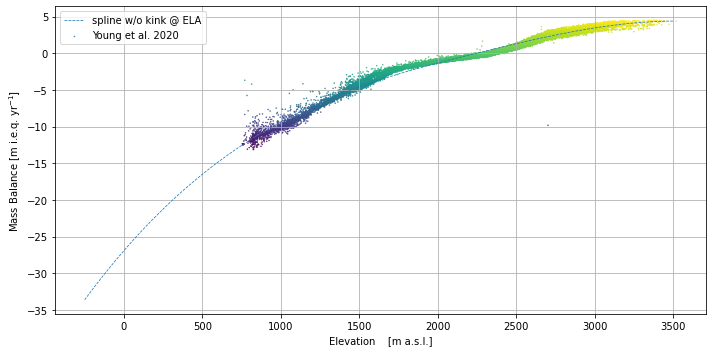

In [124]:
fig, ax = plt.subplots(1,1, sharex=True, figsize=(10,5))

z_full = np.linspace(-250, 3500, 1000)

ax.scatter(MB_ref.Elevation, 
              MB_ref.MB.mean('ref_run'),
              c=MB_ref.MB.mean('ref_run'),
              s=0.25,
              label='Young et al. 2020')


labels = ['spline with kink @ ELA', 'spline w/o kink @ ELA']

# smoothing factor 
s = 1.5e3        
w = np.where(x_ > 3000., 10.0, 1.0 )
 

tck   = interpolate.splrep(x_, y_, w=w, k=3, s=s)
cubic = interpolate.splev(z_full, tck)

ax.plot(z_full, cubic, lw = 0.75, ls = '--', label = labels[i])

np.savetxt('./data/knots.dat', tck[0])
np.savetxt('./data/coefs.dat', tck[1])
np.savetxt('./data/x_vec.dat', z_full)


ax.legend()
ax.grid(True, which='both')

ax.set_ylabel('Mass Balance [m i.e.q. yr$^{-1}$]')
ax.set_xlabel('Elevation    [m a.s.l.]')
plt.tight_layout()

In [112]:
tck2   = interpolate.splrep(z_full, cubic, k=1, s=0)
cubic2 = interpolate.splev(z_full, tck)

np.savetxt('./data/knots2.dat', tck2[0])

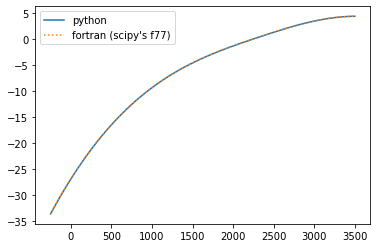

In [125]:
y_fortran = np.loadtxt('./data/y_vec.dat')

# evaluate the spline in python
y_python  = interpolate.splev(z_full, tck)

fig, ax = plt.subplots(1,1)

ax.plot(z_full, y_python , label ='python')
ax.plot(z_full, y_fortran, ':', markersize=1.0,  label='fortran (scipy\'s f77)')

plt.legend()

# plt.savefig("/Users/andrewnolan/Desktop/spline.png", dpi=400, 
#             bbox_inches='tight', facecolor='w')

In [130]:
mask = z_full > 800

def rmse(x1, x2):
    return np.sqrt(np.mean((x1 - x2)**2))

print(rmse(y_python, y_fortran))
print(LA.norm(y_python - y_fortran))

0.0
0.0
